In [24]:
from utils import query_author_id, query_conf_id
from operator import itemgetter
from collections import Counter
# import sys
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install numpy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
name_id_pairs = {
    "steve_blackburn": {"id": 2146610949, "type":"author"},
    "kathryn_mckinley": {"id": 2115847858, "type":"author"},
    "james_bornholt": {"id": 2026265091, "type":"author"},
    "julian_dolby": {"id": 2780161863, "type":"author"},
    "perry_cheng": {"id": 2140441920, "type":"author"},
    "pldi": {"id": 1127352206, "type":"conf"},
}

def get_bov(name, year=False):
    if name_id_pairs[name]["type"] == "author":
        res = query_author_id(name_id_pairs[name]["id"])
    if name_id_pairs[name]["type"] == "conf":
        res = query_conf_id(name_id_pairs[name]["id"])
    name_id_pairs[name]["numpaper"] = len(res)
    if not year:
        return get_set_of_venues(res)
    else:
        return get_set_of_venues_by_year(res)

def get_set_of_venues(res):
    references = [r["_source"]["References"] for r in res if "References" in r["_source"]]
    venues = []
    for ref in references:
        for v in ref:
            if "JournalId" in v:
                venues.append(v["JournalId"])
            if "ConferenceSeriesId" in v:
                venues.append(v["ConferenceSeriesId"])
    return venues

def get_set_of_venues_by_year(res):
    references = [(r["_source"]["Year"], r["_source"]["References"]) for r in res if "References" in r["_source"]]
    venues = {}
    for y, ref in references:
        if y not in venues:
            venues[y] = []
        for v in ref:
            if "JournalId" in v:
                venues[y].append(v["JournalId"])
            if "ConferenceSeriesId" in v:
                venues[y].append(v["ConferenceSeriesId"])
    return venues

def get_vector(bov, author_venue):
    c = Counter(author_venue)
    author_arr = [[float(c[b]) for b in bov]]
    return np.array(author_arr)

In [5]:
data = {}
for name in name_id_pairs.keys():
    data[name] = get_bov(name)

In [6]:
bag_of_venues = set()
sorted_list_bov = list()
for name, venues in data.items():
    print("{}: len(papers)={}, len(venues)={}, len(set(venues))={}".format(name, name_id_pairs[name]["numpaper"], len(venues), len(set(venues))))
    [bag_of_venues.add(v) for v in venues]
print("Total # of venues = ", len(bag_of_venues))
sorted_list_bov = list(bag_of_venues)
number_of_venues = len(sorted_list_bov)

steve_blackburn: len(papers)=79, len(venues)=1375, len(set(venues))=156
james_bornholt: len(papers)=10, len(venues)=37, len(set(venues))=20
julian_dolby: len(papers)=5, len(venues)=16, len(set(venues))=9
perry_cheng: len(papers)=51, len(venues)=308, len(set(venues))=76
pldi: len(papers)=1386, len(venues)=28209, len(set(venues))=1041
kathryn_mckinley: len(papers)=177, len(venues)=1230, len(set(venues))=135
('Total # of venues = ', 1055)


In [7]:
vec = {}
avg_vec = {}
for name, varray in data.items():
    vec[name] = get_vector(sorted_list_bov, varray)
    avg_vec[name] = vec[name]/name_id_pairs[name]["numpaper"]

# Cosine similarity

In [8]:
print(cosine_similarity(vec["steve_blackburn"], vec["kathryn_mckinley"]))
print(cosine_similarity(avg_vec["steve_blackburn"], avg_vec["kathryn_mckinley"]))

[[0.95721714]]
[[0.95721714]]


In [9]:
cosine_similarity(vec["steve_blackburn"], vec["james_bornholt"])

array([[0.35927077]])

In [10]:
cosine_similarity(vec["kathryn_mckinley"], vec["james_bornholt"])

array([[0.44655694]])

In [11]:
cosine_similarity(vec["kathryn_mckinley"], vec["pldi"])

array([[0.75491899]])

In [12]:
cosine_similarity(vec["steve_blackburn"], vec["pldi"])

array([[0.63456002]])

In [13]:
cosine_similarity(vec["perry_cheng"], vec["pldi"])

array([[0.84860174]])

In [14]:
pca = PCA(n_components=2)
def plot_pca(vec):
    X = np.zeros((len(vec),number_of_venues))
    for i, v in enumerate(vec.values()):
        X[i] = v
    # print(X)

    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    print("original shape:   ", X.shape)
    print("transformed shape:", X_pca.shape)
    z = X_pca[:, 0]
    y = X_pca[:, 1]
    plt.scatter(z, y)
    plt.axis('equal');
    for i, name in enumerate(data.keys()):
        plt.annotate(name, (z[i],y[i]))

# PCA plot sum vectors

('original shape:   ', (6, 1055))
('transformed shape:', (6, 2))


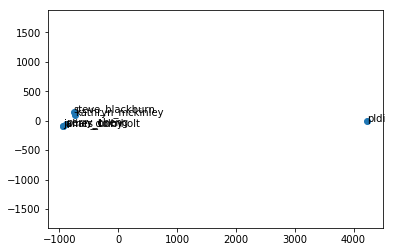

In [15]:
plot_pca(vec)

# PCA plot avg vectors

('original shape:   ', (6, 1055))
('transformed shape:', (6, 2))


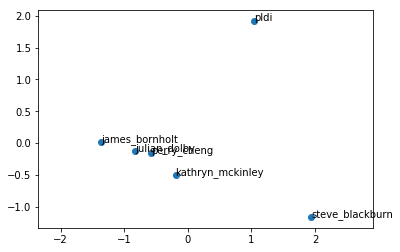

In [82]:
plot_pca(avg_vec)

In [16]:
# generate vector by year
yeardata = {}
for name in name_id_pairs.keys():
    yeardata[name] = get_bov(name, year=True)

In [17]:
def year_plot(name):
    pick = yeardata[name]
#     print((len(pick), number_of_venues))
    X = np.zeros((len(pick), number_of_venues))
    for i, v in enumerate(pick.values()):
        X[i] = get_vector(bag_of_venues, v)
#     print(X)

    pca.fit(X)
    X_pca = pca.transform(X)
    print("original shape:   ", X.shape)
    print("transformed shape:", X_pca.shape)
    
    if len(pick) > 1:
        z = X_pca[:, 0]
        y = X_pca[:, 1]
        plt.scatter(z, y)
        plt.axis('equal');
        for i, name in enumerate(pick.keys()):
            plt.annotate(name, (z[i],y[i]))
    else:
        plt.scatter([0],[0])
        plt.annotate(pick.keys()[0], (0,0))

# PCA Year plot (sum vectors)

('original shape:   ', (32, 1055))
('transformed shape:', (32, 2))


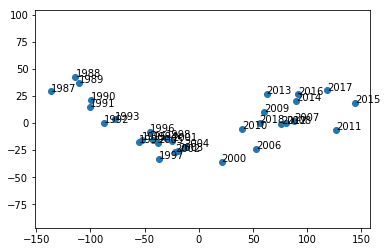

In [18]:
year_plot("pldi")

('original shape:   ', (22, 1055))
('transformed shape:', (22, 2))


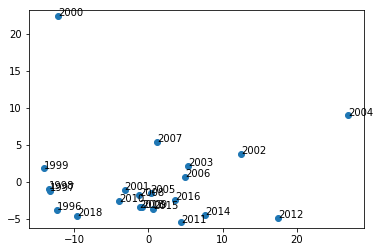

In [19]:
year_plot("steve_blackburn")

('original shape:   ', (19, 1055))
('transformed shape:', (19, 2))


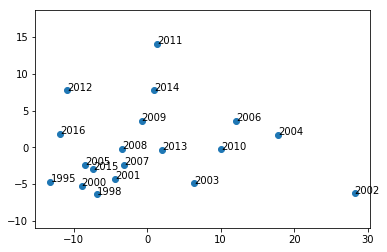

In [20]:
year_plot("kathryn_mckinley")

('original shape:   ', (8, 1055))
('transformed shape:', (8, 2))


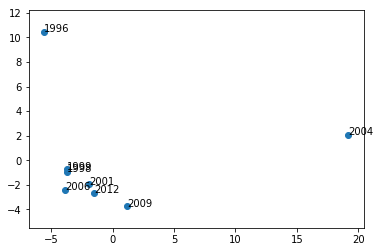

In [21]:
year_plot("perry_cheng")

('original shape:   ', (1, 1055))
('transformed shape:', (1, 1))


/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/sklearn/decomposition/pca.py:423: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


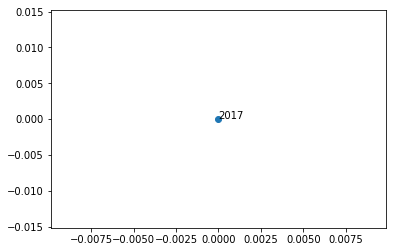

In [22]:
year_plot("james_bornholt")

('original shape:   ', (1, 1055))
('transformed shape:', (1, 1))


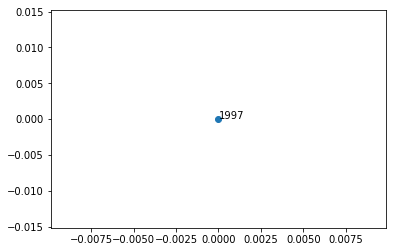

In [23]:
year_plot("julian_dolby")